<a href="https://colab.research.google.com/github/ddovidovich/DataScienceLerning/blob/main/UNIT_19_DZ_Ultra_Pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В данном задании требуется работать с библиотекой Gym, которую не проходили в рамках этой лекции. На следующем занятии *Политические методы обучения, алгоритм REINFORCE* будет рассматриваться синтаксис этой библиотеки, но вы также можете найти синтаксис в документации и в шаблонных кодах, которые выложили в интернет.

В этом задании требуется реализовать классический алгоритм Q-обучения на среде 'Taxi-v3' - т.е. нельзя использовать нейронные сети, нужно использовать Q-таблицу. В данной среде всего 500 уникальных состояний, так что Q-таблица будет работать лучше и обучаться намного быстрее, чем нейронная сеть. 

Нужную документацию можно найти по следующей ссылке: https://gym.openai.com/envs/Taxi-v3/

In [ ]:
!pip install imageio==2.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 34.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for imageio: filename=imageio-2.4.1-py3-none-any.whl size=3303886 sha256=c1fe64d3ace54d139e09543d24b05ee27f1b441065deb4457444912a95ed2a4a
  Stored in directory: /root/.cache/pip/wheels/b7/44/b7/2e7cc9c5fe4a893b9cc83a010d4410557bedf6cf3b5829f497
Successfully built imageio
  Attempting uninstall: imageio
    Found existing installation: imageio 2.25.1
    Uninstalling imageio-2.25.1:
      Successfully uninstalled imageio-2.25.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
moviepy 1.0.3 requires imageio<3.0,>=2.5; python_version >= "3.4", but you have imageio 2.4.1 which is incompatible.


Импортируем библиотеку gym.

In [ ]:
import gym         #Импортируем библиотеку gym (встроенная в колаб)
import numpy as np #Импортируем numpy
from tensorflow.keras.models import Sequential, load_model #Импортируем функцию для создания модели и загрузки модели
from tensorflow.keras.layers import * #Импортируем все слои кераса
from tensorflow.keras.optimizers import RMSprop #Импортируем оптимизатор RMSprop
import tensorflow as tf                    #Импортируем тензорфлоу
import matplotlib.pyplot as plt            #Импортируем pyplot для визуализации данных
import pickle                              #Импортируем модуль pickle для сохранения и загрузки данных
import random                              #Импортируем модуль для генерации рандомных чисел
from moviepy.editor import *               #Импортируем полезные функции из библиотеки для возпроизведение видео с результатом
import cv2                                 #Импортируем библиотеку cv2 (используется для воспроизведение видео)
from google.colab import output            #Импортируем функцию для управления вывода в колаб-ячейках

#Импортируем тип данных deque из встроенного модуля питона
from collections import deque   #deque - это список где автоматический удаляются старые значения при добовлении новых, чтобы не было переполнение памяти.

  from scipy.ndimage.filters import sobel



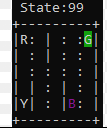

Мы будем взаимодействовать со средой, которая называется `taxi-v3`. Агент управляет такси, которая должна забирать пассажиров и доставлять их в указанные точки. Агент имеет 6 действий (забирать, доставлять, двигаться влево, двигаться вправо, двигаться вверх, двигаться вниз).

За неправильные действия (не взял пассажира, не туда сбросил пассажира, слишком долго вёз пассажира) назначаются отрициательные наргады. За своевременную доставку пассажира в нужное назначение даются положительные награды. По этому, цель алгоритма - обучиться правильно забирать и доставлять пассажиров.

In [ ]:
env = gym.make('Taxi-v3')          #Создаем игровую среду через библиотеку gym
state = env.reset()                #Начинаем новый эпизод, извлекаем состояние
print("Пример состояния:", state)  #Отображаем пример состояние (будет скалярное число)
print("Пространство действий:", env.action_space) #Смотрим на размер пространства действий

  deprecation(

  deprecation(



Пример состояния: 69
Пространство действий: Discrete(6)


### Определим параметры обучения:

In [ ]:
num_episodes = 100000         # Количество эпизодов для обучения
max_steps_per_episode = 500  # Максимальное количество шагов в каждом эпизоде
learning_rate = 0.1          # Скорость обучения
discount_rate = 0.99         # Коэффициент дисконтирования будущих наград
exploration_rate = 1.0       # Начальный коэффициент исследования
max_exploration_rate = 1.0   # Максимальный коэффициент исследования
min_exploration_rate = 0.01  # Минимальный коэффициент исследования
exploration_decay_rate = 0.001 # Скорость уменьшения коэффициента исследования

### Определим Q-таблицу, которая будет содержать значения Q-функции для каждого состояния-действия:

In [ ]:
action_size = env.action_space.n
state_size = env.observation_space.n
q_table = np.zeros((state_size, action_size))

### Определим функцию для выбора действия с учетом исследования:

In [ ]:
def choose_action(state, exploration_rate):
    # Исследование
    if np.random.uniform(0, 1) < exploration_rate:
        action = env.action_space.sample()
    # Использование
    else:
        action = np.argmax(q_table[state, :])
    return action

### Определим функцию для обновления Q-таблицы:

In [ ]:
def update_q_table(state, action, reward, next_state, learning_rate, discount_rate):
    max_action = np.argmax(q_table[next_state, :])
    q_table[state, action] = (1 - learning_rate) * q_table[state, action] + \
                             learning_rate * (reward + discount_rate * q_table[next_state, max_action])

### Начнем обучение агента:

In [ ]:
rewards = [] # Записываем награду на каждом шаге для визуализации
exploration_rates = [] # Записываем коэффициент исследования на каждом шаге для визуализации

for episode in range(num_episodes):
    state = env.reset()
    done = False
    total_reward = 0
    for step in range(max_steps_per_episode):
        # Выбор действия
        action = choose_action(state, exploration_rate)
        # Выполнение действия и получение следующего состояния, награды и флага завершения
        next_state, reward, done, info = env.step(action)
        # Обновление Q-таблицы
        update_q_table(state, action, reward, next_state, learning_rate, discount_rate)
        # Переход к следующему состоянию
        state = next_state
        # Увеличение награды
        total_reward += reward
        # Если эпизод завершен, выходим из цикла
        if done:
            break
    # Уменьшение коэффициента исследования
    exploration_rate = min_exploration_rate + \
                       (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate * episode)
    # Добавление награды и коэффициента исследования в список для визуализации
    rewards.append(total_reward)
    exploration_rates.append(exploration_rate)

    # Выводим информацию об эпизоде
    if (episode + 1) % 1000 == 0:
        print(f"Эпизод: {episode + 1}, награда: {total_reward}, коэффициент исследования: {exploration_rate:.2f}")

print("Обучение завершено.")

Эпизод: 1000, награда: -25, коэффициент исследования: 0.37
Эпизод: 2000, награда: 0, коэффициент исследования: 0.14
Эпизод: 3000, награда: 5, коэффициент исследования: 0.06
Эпизод: 4000, награда: 4, коэффициент исследования: 0.03
Эпизод: 5000, награда: 8, коэффициент исследования: 0.02
Эпизод: 6000, награда: 5, коэффициент исследования: 0.01
Эпизод: 7000, награда: 7, коэффициент исследования: 0.01
Эпизод: 8000, награда: 8, коэффициент исследования: 0.01
Эпизод: 9000, награда: 7, коэффициент исследования: 0.01
Эпизод: 10000, награда: 7, коэффициент исследования: 0.01
Эпизод: 11000, награда: 7, коэффициент исследования: 0.01
Эпизод: 12000, награда: 7, коэффициент исследования: 0.01
Эпизод: 13000, награда: 9, коэффициент исследования: 0.01
Эпизод: 14000, награда: 9, коэффициент исследования: 0.01
Эпизод: 15000, награда: 9, коэффициент исследования: 0.01
Эпизод: 16000, награда: 9, коэффициент исследования: 0.01
Эпизод: 17000, награда: 8, коэффициент исследования: 0.01
Эпизод: 18000, наград

### Визуализация награды и коэффициента исследования

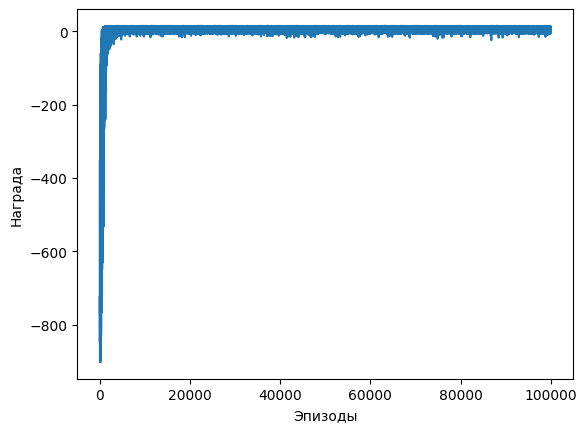

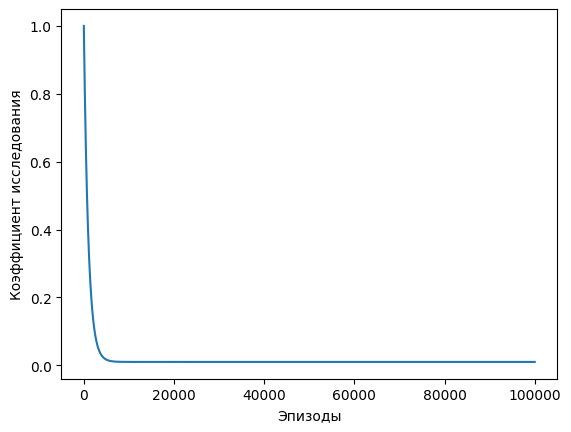

In [ ]:
plt.plot(rewards)
plt.xlabel("Эпизоды")
plt.ylabel("Награда")
plt.show()

plt.plot(exploration_rates)
plt.xlabel("Эпизоды")
plt.ylabel("Коэффициент исследования")
plt.show()

### Использование обученной модели

In [ ]:
state = env.reset()
done = False
while not done:
    # добавляем текущий кадр в список кадров
    frames.append(env.render(mode='rgb_array'))
    action = choose_action(state, 0)  # используем greedy action selection
    state, reward, done, _ = env.step(action)
 
# конвертируем кадры в видео и выводим его на экран
video = np.stack(frames)
clip = ImageSequenceClip(list(video), fps=50)
clip.ipython_display()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


### Закрываем среду

In [ ]:
env.close()